# Get the scaling of the uncertainties with the observation time (Fig. 3 of 2404.02864)

### - Start importing all libraries

In [2]:
# Global
import sys
import tqdm
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

# Local
import examples_utils as eu
import fastPTA.utils as ut
import fastPTA.plotting_functions as pf
from fastPTA.signals import get_signal_model
from fastPTA.Fisher_code import compute_fisher

### - Constants to be used in the analysis

In [3]:
# Number of frequencies used in the analysis
n_frequencies = 30

# Number of pulsars in the analysis
n_pulsars = 50

# Signal model to be used in the analysis
signal_label = "power_law"

# The analysis assumes a power law template, specify here the input parameters
log_amplitude = -7.1995  # log amplitude
tilt = 2.0  # Tilt

# Parameters for the HD computations:
# Method to compute the HD, either "Legendre" or "Binned"
HD_basis = "Legendre"

# Maximum order of the Legendre polynomials
HD_order = 0

# Whether to add some gaussian prior for the HD coefficients to the Fisher matrix
add_HD_prior = False

# Specify the type of noise to be used in the analysis
which_experiment = eu.EPTAlike

# Whether you want to rerun the analysis
rerun = False

# Minimum number of years to be used in the analysis
T_min_yrs = 0.1

# Maximum number of years to be used in the analysis
T_max_yrs = 200

# Number of points in T to scan over
T_times = 15

# Number of realizations to be generated for each value of T
N_realizations = 10

# Name of the outfile, no need for the extension
# (will be stored in generated_data/)
outname = "Default"

### - Builds the dictionaries with inputs for the code

In [4]:
# Get the signal model
signal_model = get_signal_model(signal_label)

# Assemble the vector with two signal parameters
signal_parameters = np.array([log_amplitude, tilt])

# Length of the parameter vector
parameter_len = (
    len(signal_parameters) + HD_order + 1
    if HD_order
    else len(signal_parameters)
)

# Dictionary with the kwargs to generete the pulsar catalogs
default_pulsars = {
    "n_pulsars": n_pulsars,
    "save_catalog": False,
    **which_experiment,
}

# Dictionary with the kwargs to generate noise and orf tensors
get_tensors_kwargs = {
    "add_curn": False,
    "HD_order": HD_order,
    "HD_basis": HD_basis,
    "regenerate_catalog": True,
}

# Dictionary with the kwargs to generate the fisher matrix
fisher_kwargs = {
    "T_obs_yrs": 1.0,
    "n_frequencies": n_frequencies,
    "signal_parameters": signal_parameters,
}

### - Check if all the folders are in place and define save_path

In [5]:
# Build the save path
if outname != "Default":
    save_path = "generated_data/" + outname + ".npz"
elif HD_order == 0:
    save_path = "generated_data/T_scaling.npz"
else:
    save_path = "generated_data/T_scaling_HD.npz"

### - Run for all values of T_obs

In [6]:
try:
    # Check if the file is there and load the data if not rerun
    if rerun:
        raise FileNotFoundError("Forcing regeneration")

    data = np.load(save_path)

    T_obs_values = data["T_obs_values"]
    SNR_values = data["SNR_values"]
    parameters_uncertainties = data["parameters_uncertainties"]

except FileNotFoundError:

    # Define the vector with the values of T_obs to scan over
    T_obs_values = np.geomspace(T_min_yrs, T_max_yrs, T_times)

    # Initialize the arrays to store the results
    SNR_values = np.zeros(shape=(T_times, N_realizations))
    parameters_uncertainties = np.zeros(
        shape=(T_times, N_realizations, parameter_len)
    )

    # Loop over the values of T_obs
    for i in range(T_times):
        # Set the value of T_obs
        generate_catalog_kwargs = default_pulsars.copy()
        generate_catalog_kwargs["T_span_dict"] = {
            "which_distribution": "gaussian",
            "mean": np.log10(T_obs_values[i]),
            "std": 0.0125,
        }

        fisher_kwargs["T_obs_yrs"] = T_obs_values[i]
        fisher_kwargs["n_frequencies"] = n_frequencies + int(T_obs_values[i])

        # Compute the fisher for all the realizations at a given T_obs
        print("Here starts T = %.2f yrs" % (T_obs_values[i]))
        for j in tqdm.tqdm(range(N_realizations)):
            (
                frequency,
                signal,
                HD_functions_IJ,
                HD_coeffs,
                effective_noise,
                SNR,
                fisher,
            ) = compute_fisher(
                **fisher_kwargs,
                get_tensors_kwargs=get_tensors_kwargs,
                generate_catalog_kwargs=generate_catalog_kwargs,
            )

            if HD_order and add_HD_prior:
                fisher += np.diag(
                    np.append(
                        np.zeros(len(signal_parameters)), np.ones(HD_order + 1)
                    )
                )

            # Get covariance matrix and errors
            c_inverse = ut.compute_inverse(fisher)
            errors = np.sqrt(np.diag(c_inverse))

            # Store the results
            SNR_values[i, j] = SNR
            parameters_uncertainties[i, j] = errors

        SNR_mean = np.mean(SNR_values[i], axis=-1)
        SNR_std = np.std(SNR_values[i], axis=-1)
        print("SNR=%.2e +-%.2e \n" % (SNR_mean, SNR_std))

    to_save = {
        "T_obs_values": T_obs_values,
        "SNR_values": SNR_values,
        "parameters_uncertainties": parameters_uncertainties,
    }

    np.savez(save_path, **to_save)

Here starts T = 0.10 yrs


100%|██████████| 10/10 [00:00<00:00, 14.36it/s]


SNR=6.82e-05 +-3.99e-05 

Here starts T = 0.17 yrs


100%|██████████| 10/10 [00:00<00:00, 230.36it/s]


SNR=5.39e-04 +-3.85e-04 

Here starts T = 0.30 yrs


100%|██████████| 10/10 [00:00<00:00, 218.08it/s]


SNR=2.37e-03 +-9.18e-04 

Here starts T = 0.51 yrs


100%|██████████| 10/10 [00:00<00:00, 226.28it/s]


SNR=2.57e-02 +-2.91e-02 

Here starts T = 0.88 yrs


100%|██████████| 10/10 [00:00<00:00, 224.15it/s]


SNR=9.87e-02 +-5.72e-02 

Here starts T = 1.51 yrs


100%|██████████| 10/10 [00:00<00:00, 24.34it/s]


SNR=5.75e-01 +-2.38e-01 

Here starts T = 2.60 yrs


100%|██████████| 10/10 [00:00<00:00, 23.97it/s]


SNR=1.53e+00 +-3.47e-01 

Here starts T = 4.47 yrs


100%|██████████| 10/10 [00:00<00:00, 24.90it/s]


SNR=3.40e+00 +-4.08e-01 

Here starts T = 7.70 yrs


100%|██████████| 10/10 [00:00<00:00, 20.64it/s]


SNR=5.83e+00 +-7.30e-01 

Here starts T = 13.25 yrs


100%|██████████| 10/10 [00:00<00:00, 23.25it/s]


SNR=9.12e+00 +-8.03e-01 

Here starts T = 22.80 yrs


100%|██████████| 10/10 [00:00<00:00, 24.25it/s]


SNR=1.31e+01 +-1.47e+00 

Here starts T = 39.23 yrs


100%|██████████| 10/10 [00:00<00:00, 22.91it/s]


SNR=1.77e+01 +-1.04e+00 

Here starts T = 67.52 yrs


100%|██████████| 10/10 [00:00<00:00, 21.83it/s]


SNR=2.62e+01 +-1.68e+00 

Here starts T = 116.21 yrs


100%|██████████| 10/10 [00:00<00:00, 19.86it/s]


SNR=3.63e+01 +-2.05e+00 

Here starts T = 200.00 yrs


100%|██████████| 10/10 [00:00<00:00, 15.71it/s]

SNR=4.91e+01 +-2.94e+00 



### - Compute means and stds

In [7]:
# Mean and std of the SNR over the realizations
SNR_mean = np.mean(SNR_values, axis=-1)
SNR_std = np.std(SNR_values, axis=-1)

# Mean and std of the uncertainties over the realizations
uncertainties_means = np.mean(parameters_uncertainties, axis=1)
uncertainties_stds = np.std(parameters_uncertainties, axis=1)

### - Plot the scaling of SNR with T_obs

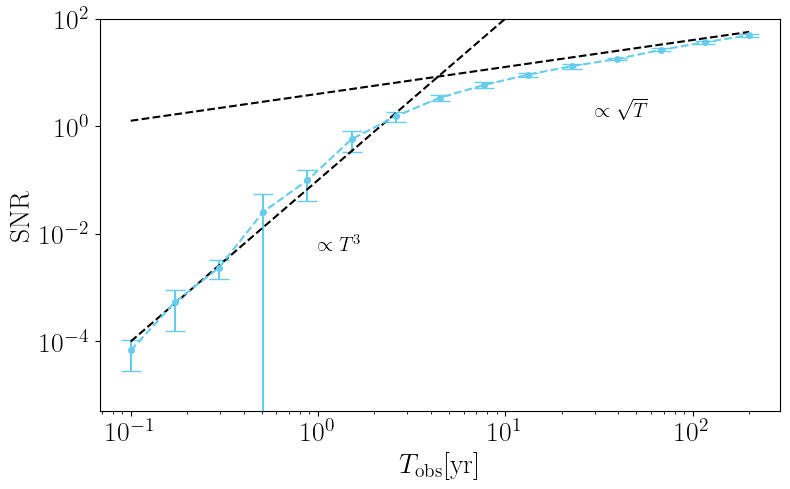

In [8]:
plt.figure(figsize=(8, 5))

plt.errorbar(
    T_obs_values,
    SNR_mean,
    yerr=SNR_std,
    color=pf.my_colormap["cyan"],
    fmt="o",
    markersize=4,
    linestyle="dashed",
    capsize=7,
)

# plot x**3
plt.loglog(T_obs_values, 0.1 * T_obs_values**3, linestyle="--", color="black")
plt.text(1, 5e-3, s=r"$\propto T^3$", fontsize=15)

# plot x**(1/2)
plt.loglog(T_obs_values, 4 * T_obs_values**0.5, linestyle="--", color="black")
plt.text(30, 1.5, s=r"$\propto \sqrt{T}$", fontsize=15)

plt.xlabel(r"$T_{\rm obs} \rm [yr]$")
plt.ylabel(r"$\rm SNR$")
plt.ylim(5e-6, 1e2)
plt.tight_layout()
plt.savefig("plots/SNR_T_scaling.pdf")

### - Plot the scaling of uncertainties on the SGWB shape parameters with T_obs

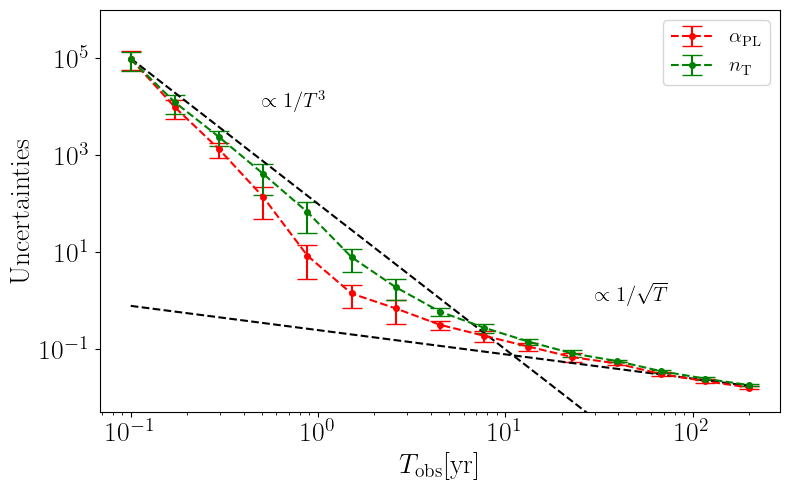

In [9]:
plt.figure(figsize=(8, 5))
for i in range(len(signal_parameters)):
    colors = list(pf.my_colormap.keys())
    col = colors[np.mod(i, len(colors))]
    plt.errorbar(
        T_obs_values,
        uncertainties_means[:, i],
        yerr=uncertainties_stds[:, i],
        color=col,
        fmt="o",
        markersize=4,
        linestyle="dashed",
        capsize=7,
        label=signal_model.parameter_labels[i],
    )

plt.loglog(
    T_obs_values,
    100 / T_obs_values**3,
    linestyle="--",
    color="black",
)

plt.text(0.5, 1e4, s=r"$\propto 1/T^3$", fontsize=15)

plt.loglog(
    T_obs_values,
    0.25 / T_obs_values ** (1 / 2),
    linestyle="--",
    color="black",
)

plt.text(30, 1, s=r"$\propto 1/\sqrt{T}$", fontsize=15)

plt.xlabel(r"$T_{\rm obs} \rm [yr]$")
plt.ylabel(r"$\rm Uncertainties$")
plt.ylim(5e-3, 1e6)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig("plots/Error_T_scaling.pdf")